## Model Interpretation on Loan Data --Yidan Li yl4357

## Table of Content
* [1.Data Preparation](#1)
 * [Drop highly missing/ single value/ not meaningful variables](#1.1)
 * [Replacing missing and special values](#1.2)
 * [Encoding categorical and string variables](#1.3)
* [2. Feature Selection using GBM in h2o](#2)
* [3.Random Forest Model with scikit-learn](#3)
* [4.Model Interpretation with SHAP value](#4)
 * [Global Interpretability: Variable Importance Plot](#4.1)
 * [Global Interpretability: Dependence Plot](#4.2)
 * [Local Interpretability: Individual Force Plot](#4.3)

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import plotly
import plotly.express as px
import seaborn as sns

In [2]:
df=pd.read_csv('/Users/liyidan/Desktop/Anomaly Detection/8. Supervised Learning/XYZloan_default_selected_vars.csv')
print(df.head(3))
print(df['loan_default'].value_counts())

   Unnamed: 0  Unnamed: 0.1  id  loan_default  AP001  AP002  AP003  AP004  \
0           0             1   1             1     31      2      1     12   
1           1             2   2             0     27      1      1     12   
2           2             3   3             0     33      1      4     12   

            AP005 AP006  ...  CD162  CD164  CD166  CD167   CD169   CD170  \
0  2017/7/6 10:21   ios  ...   13.0   13.0    0.0    0.0  1449.0  1449.0   
1  2017/4/6 12:51    h5  ...  -99.0  -99.0  -99.0  -99.0   -99.0   -99.0   
2  2017/7/1 14:11    h5  ...    3.0    2.0   33.0    0.0    33.0     0.0   

    CD172   CD173  MB005    MB007  
0  2249.0  2249.0    7.0  IPHONE7  
1   -99.0   -99.0    NaN      WEB  
2   143.0   110.0    8.0      WEB  

[3 rows x 89 columns]
0    64512
1    15488
Name: loan_default, dtype: int64


### 1. Data Preparation <a class="anchor" id="1"></a>

Explore the columns with missing value and their data types

In [3]:
null_cols=df.columns[df.isnull().any()]
print(null_cols)  #columns with NA values
print(df.select_dtypes(include=['float64','int64']).columns)  #numeric columns
print(df.select_dtypes(include=['object']).columns)  #string columns
#all columns with NA values are numeric

Index(['TD022', 'TD023', 'TD024', 'TD025', 'TD026', 'TD027', 'TD028', 'TD029',
       'TD044', 'TD048', 'TD051', 'TD054', 'TD055', 'TD061', 'TD062', 'PA022',
       'PA023', 'PA028', 'PA029', 'PA030', 'PA031', 'CD008', 'CD018', 'CD071',
       'CD072', 'CD088', 'CD100', 'CD101', 'CD106', 'CD107', 'CD108', 'CD113',
       'CD114', 'CD115', 'CD117', 'CD118', 'CD120', 'CD121', 'CD123', 'CD130',
       'CD131', 'CD132', 'CD133', 'CD135', 'CD136', 'CD137', 'CD152', 'CD153',
       'CD160', 'CD162', 'CD164', 'CD166', 'CD167', 'CD169', 'CD170', 'CD172',
       'CD173', 'MB005'],
      dtype='object')
Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'loan_default', 'AP001', 'AP002',
       'AP003', 'AP004', 'AP007', 'AP008', 'AP009', 'TD001', 'TD002', 'TD005',
       'TD006', 'TD009', 'TD010', 'TD013', 'TD014', 'TD015', 'TD022', 'TD023',
       'TD024', 'TD025', 'TD026', 'TD027', 'TD028', 'TD029', 'TD044', 'TD048',
       'TD051', 'TD054', 'TD055', 'TD061', 'TD062', 'CR004', 'CR005', 'CR009',
      

#### Drop highly missing/ single value/ not meaningful variables <a class="anchor" id="1.1"></a>

In [4]:
#drop variables that are not meaningful for prediction
df=df.drop(['id','Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [5]:
#drop variables with only 1 unique value (including all missing variables)
for col in df.columns:
    if df[col].nunique() == 1:
        df.drop(col,inplace=True,axis=1)

In [6]:
#further examine columns with missing values
def missing_values_table(df):
        mis_val = df.isnull().sum()
        mis_val_percent =100*df.isnull().sum() / len(df)
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Missing Values'})
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Missing Values', ascending=False).round(1)

        print ("The dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        return mis_val_table_ren_columns
missing_values_table(df)

The dataframe has 73 columns.
There are 46 columns that have missing values.


,Missing Values,% of Missing Values
TD022,19598,24.5
TD023,7663,9.6
TD024,3694,4.6
MB005,2793,3.5
PA023,381,0.5
CD153,381,0.5
CD130,381,0.5
CD131,381,0.5
CD132,381,0.5
CD133,381,0.5


In [7]:
pd.options.display.max_columns = 100
df.describe()

,loan_default,AP001,AP002,AP003,AP004,AP007,AP008,AP009,TD001,TD002,TD005,TD006,TD009,TD010,TD013,TD014,TD015,TD022,TD023,TD024,CR004,CR005,CR009,CR015,CR017,CR018,CR019,PA022,PA023,PA028,PA029,PA030,PA031,CD008,CD018,CD071,CD072,CD088,CD100,CD101,CD106,CD107,CD108,CD113,CD114,CD115,CD117,CD118,CD120,CD121,CD123,CD130,CD131,CD132,CD133,CD135,CD136,CD137,CD152,CD153,CD160,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005
count,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.000000,80000.00000,80000.000000,80000.000000,80000.000000,80000.000000,60402.000000,72337.000000,76306.000000,80000.000000,80000.000000,8.000000e+04,80000.000000,80000.000000,80000.000000,80000.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.00000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,7.961900e+04,7.961900e+04,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.000000,79619.00000,79619.000000,79619.000000,77207.000000
mean,0.193600,31.706913,1.321813,2.014925,11.235413,3.30130,3.117200,0.727925,1.986962,0.706213,3.593037,1.345700,5.40600,2.020812,6.804737,2.603662,0.718775,17.120294,7.293156,5.541687,2.503450,1.595638,3.518711e+04,4.924750,5.234962,4.361112,6.199038,19.298811,14.828822,-36.738300,-42.407356,-74.438095,-48.404044,13470.599066,426.021427,34.502167,30.631106,40.050993,4.812457,0.586883,9.460857,3.010374,2.331253,-0.594243,1.176352,68.37697,48.368995,115.663070,83.749532,155.066228,113.074379,88.081815,81.524159,99.278916,108.111493,130.041146,120.280850,143.578153,1.360805e+04,1.366809e+04,6.911956,14.271694,11.773358,909.089313,810.786219,1732.693314,1539.33443,2513.226491,2229.606137,5.976272
std,0.395121,7.075070,0.467174,1.196806,2.212313,1.33655,1.306335,0.445031,1.807445,0.918347,2.799570,1.413362,4.02311,1.973988,5.128183,2.505840,0.882962,7.024737,7.395779,6.157043,1.117991,1.083602,6.359684e+04,1.094305,2.398870,2.498607,3.359354,39.705478,37.009374,100.731779,97.006168,74.146246,96.313406,13058.772406,373.327926,66.483870,61.899563,78.969397,43.655893,29.029802,61.423633,37.172491,35.030955,21.642171,23.311023,60.57446,46.932544,91.713711,69.112448,116.368152,86.765922,90.320004,88.529928,96.068148,96.793174,123.525977,120.935487,130.487618,1.905389e+04,1.935326e+04,28.007499,38.235012,33.270641,1379.553332,1245.044602,2441.503517,2172.71384,3404.975112,3005.615048,3.641814
min,0.000000,20.000000,1.000000,1.000000,3.000000,1.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,1.000000,1.000000,0.000000e+00,2.000000,1.000000,0.000000,1.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.00000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-9.900000e+01,-9.900000e+01,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.000000,-99.00000,-99.000000,-99.000000,0.000000
25%,0.000000,27.000000,1.000000,1.000000,12.000000,2.00000,2.000000,0.000000,1.000000,0.000000,2.000000,0.000000,3.00000,1.000000,3.000000,1.000000,0.000000,10.000000,3.000000,2.000000,2.000000,1.000000,4.700000e+03,5.000000,3.000000,2.000000,3.000000,-1.000000,-1.000000,-98.000000,-98.000000,-98.000000,-98.000000,4769.500000,163.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,38.00000,28.000000,65.000000,48.000000,88.000000,65.000000,31.000000,26.000000,40.000000,48.000000

According to the variable description, variable PA022-CD173 are all continuous variables and should all be positive, but they all have negative values inside as shown in the above statistics, like -99, -1, which should be put in a new category, these variables will be included in the same category with NA values.

#### Replacing missing and special values <a class="anchor" id="1.2"></a>

In [8]:
var_with_na=df.columns[df.isnull().any()]
var_with_na

Index(['TD022', 'TD023', 'TD024', 'PA022', 'PA023', 'PA028', 'PA029', 'PA030',
       'PA031', 'CD008', 'CD018', 'CD071', 'CD072', 'CD088', 'CD100', 'CD101',
       'CD106', 'CD107', 'CD108', 'CD113', 'CD114', 'CD115', 'CD117', 'CD118',
       'CD120', 'CD121', 'CD123', 'CD130', 'CD131', 'CD132', 'CD133', 'CD135',
       'CD136', 'CD137', 'CD152', 'CD153', 'CD160', 'CD162', 'CD164', 'CD166',
       'CD167', 'CD169', 'CD170', 'CD172', 'CD173', 'MB005'],
      dtype='object')

In [9]:
for var in var_with_na:
    df[[var]]=df[[var]].fillna(0)
    df[[var]]=df[[var]].replace(-99,0)
    df[[var]]=df[[var]].replace(-98,0)
    df[[var]]=df[[var]].replace(-1,0)

In [10]:
df.head(3)

,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,TD001,TD002,TD005,TD006,TD009,TD010,TD013,TD014,TD015,TD022,TD023,TD024,CR004,CR005,CR009,CR015,CR017,CR018,CR019,PA022,PA023,PA028,PA029,PA030,PA031,CD008,CD018,CD071,CD072,CD088,CD100,CD101,CD106,CD107,CD108,CD113,CD114,CD115,CD117,CD118,CD120,CD121,CD123,CD130,CD131,CD132,CD133,CD135,CD136,CD137,CD152,CD153,CD160,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007
0,1,31,2,1,12,2017/7/6 10:21,ios,3,3,1,1,1,4,1,5,1,14,2,2,10.0,9.0,6.0,2,1,35807,4,4,3,2,0.0,0.0,0.0,0.0,0.0,0.0,13840.0,172.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,57.0,48.0,95.0,79.0,125.0,103.0,43.0,55.0,56.0,52.0,65.0,91.0,96.0,10900.0,12757.0,8.0,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7
1,0,27,1,1,12,2017/4/6 12:51,h5,5,4,0,2,0,3,1,3,1,3,2,0,15.0,6.0,0.0,3,1,7254,6,7,6,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WEB
2,0,33,1,4,12,2017/7/1 14:11,h5,4,2,0,2,1,4,1,5,1,9,1,2,15.0,9.0,2.0,2,2,30377,2,2,2,3,0.0,0.0,0.0,0.0,0.0,0.0,2454.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,20.0,20.0,23.0,21.0,11.0,9.0,10.0,12.0,13.0,9.0,11.0,3807.0,2314.0,0.0,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB


#### Encoding categorical and string variables (AP002, AP005, AP006, MB007)  <a class="anchor" id="1.3"></a>

In [11]:
#AP002 is gender, encode as 0/1
df['AP002']=df['AP002'].replace(2,0)

In [12]:
df.AP005

0         2017/7/6 10:21
1         2017/4/6 12:51
2         2017/7/1 14:11
3         2017/7/7 10:10
4         2017/7/6 14:37
              ...       
79995     2017/5/7 13:44
79996     2017/6/2 15:54
79997      2017/7/9 8:40
79998     2017/5/9 10:19
79999    2017/4/27 18:36
Name: AP005, Length: 80000, dtype: object

In [13]:
#extract year, month, day, hour, weekday from AP005
from datetime import datetime
df['AP005'] = pd.to_datetime(df['AP005'])
df['weekday'] = pd.DatetimeIndex(df['AP005']).dayofweek

In [14]:
#age data
df['AP001'].isnull().sum()
df['AP001']=pd.cut(df['AP001'], bins=4,labels=["20-29", "29-38", "38-47","47-56"])

In [15]:
dummies = pd.get_dummies(df['AP001'])
dummies.head()
df1=pd.concat([df, dummies], axis=1)
df1.head()

,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,TD001,TD002,TD005,TD006,TD009,TD010,TD013,TD014,TD015,TD022,TD023,TD024,CR004,CR005,CR009,CR015,CR017,CR018,CR019,PA022,PA023,PA028,PA029,PA030,PA031,CD008,CD018,CD071,CD072,CD088,CD100,CD101,CD106,CD107,CD108,CD113,CD114,CD115,CD117,CD118,CD120,CD121,CD123,CD130,CD131,CD132,CD133,CD135,CD136,CD137,CD152,CD153,CD160,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007,weekday,20-29,29-38,38-47,47-56
0,1,29-38,0,1,12,2017-07-06 10:21:00,ios,3,3,1,1,1,4,1,5,1,14,2,2,10.0,9.0,6.0,2,1,35807,4,4,3,2,0.0,0.0,0.0,0.0,0.0,0.0,13840.0,172.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,57.0,48.0,95.0,79.0,125.0,103.0,43.0,55.0,56.0,52.0,65.0,91.0,96.0,10900.0,12757.0,8.0,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7,3,0,1,0,0
1,0,20-29,1,1,12,2017-04-06 12:51:00,h5,5,4,0,2,0,3,1,3,1,3,2,0,15.0,6.0,0.0,3,1,7254,6,7,6,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WEB,3,1,0,0,0
2,0,29-38,1,4,12,2017-07-01 14:11:00,h5,4,2,0,2,1,4,1,5,1,9,1,2,15.0,9.0,2.0,2,2,30377,2,2,2,3,0.0,0.0,0.0,0.0,0.0,0.0,2454.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,20.0,20.0,23.0,21.0,11.0,9.0,10.0,12.0,13.0,9.0,11.0,3807.0,2314.0,0.0,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB,5,0,1,0,0
3,0,29-38,0,4,12,2017-07-07 10:10:00,android,5,5,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0.0,2,1,0,5,7,7,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,OPPO,4,0,1,0,0
4,0,38-47,0,1,12,2017-07-06 14:37:00,h5,4,4,1,2,0,2,1,2,1,2,1,0,10.0,3.0,0.0,4,2,0,6,8,7,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WEB,3,0,0,1,0


In [16]:
dummies = pd.get_dummies(df['AP006'])
dummies.head()
df2=pd.concat([df1, dummies], axis=1)
df2.head()

,loan_default,AP001,AP002,AP003,AP004,AP005,AP006,AP007,AP008,AP009,TD001,TD002,TD005,TD006,TD009,TD010,TD013,TD014,TD015,TD022,TD023,TD024,CR004,CR005,CR009,CR015,CR017,CR018,CR019,PA022,PA023,PA028,PA029,PA030,PA031,CD008,CD018,CD071,CD072,CD088,CD100,CD101,CD106,CD107,CD108,CD113,CD114,CD115,CD117,CD118,CD120,CD121,CD123,CD130,CD131,CD132,CD133,CD135,CD136,CD137,CD152,CD153,CD160,CD162,CD164,CD166,CD167,CD169,CD170,CD172,CD173,MB005,MB007,weekday,20-29,29-38,38-47,47-56,android,api,h5,ios
0,1,29-38,0,1,12,2017-07-06 10:21:00,ios,3,3,1,1,1,4,1,5,1,14,2,2,10.0,9.0,6.0,2,1,35807,4,4,3,2,0.0,0.0,0.0,0.0,0.0,0.0,13840.0,172.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,57.0,48.0,95.0,79.0,125.0,103.0,43.0,55.0,56.0,52.0,65.0,91.0,96.0,10900.0,12757.0,8.0,13.0,13.0,0.0,0.0,1449.0,1449.0,2249.0,2249.0,7.0,IPHONE7,3,0,1,0,0,0,0,0,1
1,0,20-29,1,1,12,2017-04-06 12:51:00,h5,5,4,0,2,0,3,1,3,1,3,2,0,15.0,6.0,0.0,3,1,7254,6,7,6,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WEB,3,1,0,0,0,0,0,1,0
2,0,29-38,1,4,12,2017-07-01 14:11:00,h5,4,2,0,2,1,4,1,5,1,9,1,2,15.0,9.0,2.0,2,2,30377,2,2,2,3,0.0,0.0,0.0,0.0,0.0,0.0,2454.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,13.0,20.0,20.0,23.0,21.0,11.0,9.0,10.0,12.0,13.0,9.0,11.0,3807.0,2314.0,0.0,3.0,2.0,33.0,0.0,33.0,0.0,143.0,110.0,8.0,WEB,5,0,1,0,0,0,0,1,0
3,0,29-38,0,4,12,2017-07-07 10:10:00,android,5,5,0,0,0,0,0,0,0,1,1,0,0.0,0.0,0.0,2,1,0,5,7,7,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,OPPO,4,0,1,0,0,1,0,0,0
4,0,38-47,0,1,12,2017-07-06 14:37:00,h5,4,4,1,2,0,2,1,2,1,2,1,0,10.0,3.0,0.0,4,2,0,6,8,7,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,WEB,3,0,0,1,0,0,0,1,0


In [17]:
df2.columns

Index(['loan_default', 'AP001', 'AP002', 'AP003', 'AP004', 'AP005', 'AP006',
       'AP007', 'AP008', 'AP009', 'TD001', 'TD002', 'TD005', 'TD006', 'TD009',
       'TD010', 'TD013', 'TD014', 'TD015', 'TD022', 'TD023', 'TD024', 'CR004',
       'CR005', 'CR009', 'CR015', 'CR017', 'CR018', 'CR019', 'PA022', 'PA023',
       'PA028', 'PA029', 'PA030', 'PA031', 'CD008', 'CD018', 'CD071', 'CD072',
       'CD088', 'CD100', 'CD101', 'CD106', 'CD107', 'CD108', 'CD113', 'CD114',
       'CD115', 'CD117', 'CD118', 'CD120', 'CD121', 'CD123', 'CD130', 'CD131',
       'CD132', 'CD133', 'CD135', 'CD136', 'CD137', 'CD152', 'CD153', 'CD160',
       'CD162', 'CD164', 'CD166', 'CD167', 'CD169', 'CD170', 'CD172', 'CD173',
       'MB005', 'MB007', 'weekday', '20-29', '29-38', '38-47', '47-56',
       'android', 'api', 'h5', 'ios'],
      dtype='object')

In [18]:
df=df2[['loan_default', 'AP002', 'AP003', 'AP004',
       'AP007', 'AP008', 'AP009', 'TD001', 'TD002', 'TD005', 'TD006', 'TD009',
       'TD010', 'TD013', 'TD014', 'TD015', 'TD022', 'TD023', 'TD024', 'CR004',
       'CR005', 'CR009', 'CR015', 'CR017', 'CR018', 'CR019', 'PA022', 'PA023',
       'PA028', 'PA029', 'PA030', 'PA031', 'CD008', 'CD018', 'CD071', 'CD072',
       'CD088', 'CD100', 'CD101', 'CD106', 'CD107', 'CD108', 'CD113', 'CD114',
       'CD115', 'CD117', 'CD118', 'CD120', 'CD121', 'CD123', 'CD130', 'CD131',
       'CD132', 'CD133', 'CD135', 'CD136', 'CD137', 'CD152', 'CD153', 'CD160',
       'CD162', 'CD164', 'CD166', 'CD167', 'CD169', 'CD170', 'CD172', 'CD173',
       'MB005','20-29', '29-38', '38-47', '47-56',
       'android', 'api', 'h5', 'ios']]

In [19]:
df.isnull().sum().sum()

0

In [20]:
#End of data preparation

### 2. Feature Selection using GBM in h2o <a class="anchor" id="2"></a>

In [273]:
import h2o
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "11.0.9" 2020-10-20 LTS; Java(TM) SE Runtime Environment 18.9 (build 11.0.9+7-LTS); Java HotSpot(TM) 64-Bit Server VM 18.9 (build 11.0.9+7-LTS, mixed mode)
  Starting server from /Users/liyidan/opt/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/42/vq68331n3z93l2vf5h3j7h780000gn/T/tmpm3z96c0y
  JVM stdout: /var/folders/42/vq68331n3z93l2vf5h3j7h780000gn/T/tmpm3z96c0y/h2o_liyidan_started_from_python.out
  JVM stderr: /var/folders/42/vq68331n3z93l2vf5h3j7h780000gn/T/tmpm3z96c0y/h2o_liyidan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,2 months
H2O_cluster_name:,H2O_from_python_liyidan_uc5ekg
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [286]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(
     df,stratify=df['loan_default'], test_size=0.30, random_state=1)

In [287]:
print(train.shape)
print(test.shape)

(56000, 77)
(24000, 77)


In [288]:
train_hex = h2o.H2OFrame(train)
test_hex = h2o.H2OFrame(test)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [289]:
predictors=train.drop(labels=['loan_default'], axis=1).columns.to_list()
target='loan_default'

In [290]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
gbm = H2OGradientBoostingEstimator(model_id='gbm',ntrees=300,nfolds=5, max_depth=5,
                                       min_rows=10,learn_rate=0.05,seed=1234)
gbm.train(predictors,target,training_frame=train_hex)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [291]:
def VarImp(model_name):
    
    from sklearn.metrics import roc_curve,auc
    from sklearn.metrics import average_precision_score
    from sklearn.metrics import precision_recall_curve
    import matplotlib.pyplot as plt
    
    # plot the variable importance
    plt.rcdefaults()
    variables = model_name._model_json['output']['variable_importances']['variable']
    y_pos = np.arange(len(variables))
    fig, ax = plt.subplots(figsize = (6,len(variables)/2))
    scaled_importance = model_name._model_json['output']['variable_importances']['scaled_importance']
    ax.barh(y_pos,scaled_importance,align='center',color='green')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(variables)
    ax.invert_yaxis()
    ax.set_xlabel('Scaled Importance')
    ax.set_title('Variable Importance')
    plt.show()

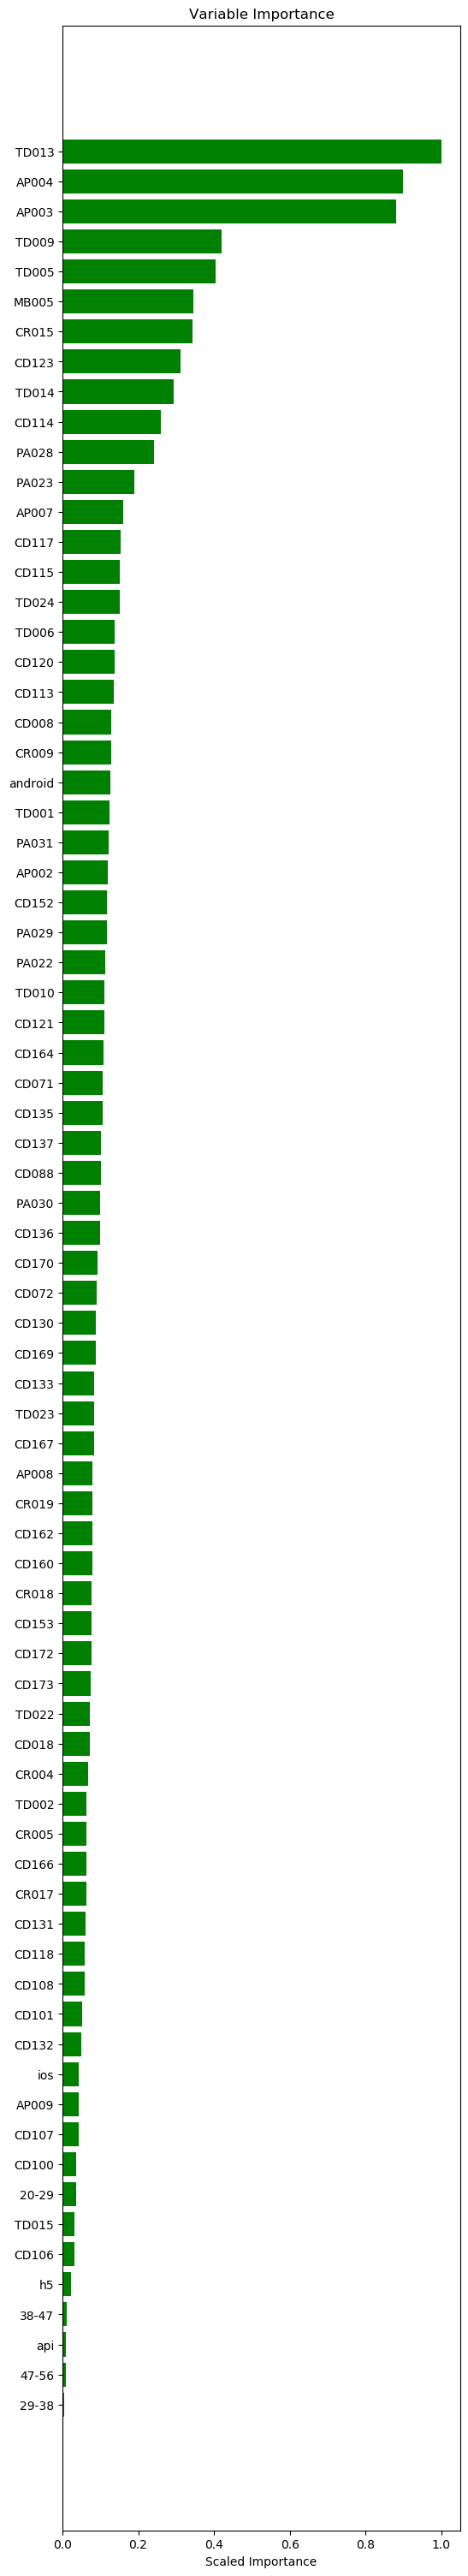

In [292]:
VarImp(gbm)

In [23]:
#select the top 30 
df_selected=df[['loan_default', 
                'AP002', 'AP003', 'AP004', 'AP007', 'TD001', 'TD005', 
                'TD006', 'TD009','TD010', 'TD013', 'TD014', 'TD024', 
                'CR009', 'CR015', 'PA022', 'PA023','PA028', 'PA029',
                'PA031', 'CD008','CD113', 'CD114', 'CD115', 'CD117',
                'CD120', 'CD121', 'CD123', 'CD152', 'MB005', 'android']]

In [24]:
df_selected

,loan_default,AP002,AP003,AP004,AP007,TD001,TD005,TD006,TD009,TD010,TD013,TD014,TD024,CR009,CR015,PA022,PA023,PA028,PA029,PA031,CD008,CD113,CD114,CD115,CD117,CD120,CD121,CD123,CD152,MB005,android
0,1,0,1,12,3,1,4,1,5,1,14,2,6.0,35807,4,0.0,0.0,0.0,0.0,0.0,13840.0,0.0,1.0,57.0,48.0,79.0,125.0,103.0,10900.0,7.0,0
1,0,1,1,12,5,2,3,1,3,1,3,2,0.0,7254,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,1,4,12,4,2,4,1,5,1,9,1,2.0,30377,2,0.0,0.0,0.0,0.0,0.0,2454.0,0.0,0.0,13.0,13.0,20.0,23.0,21.0,3807.0,8.0,0
3,0,0,4,12,5,0,0,0,0,0,1,1,0.0,0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,1
4,0,0,1,12,4,2,2,1,2,1,2,1,0.0,0,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79995,0,0,1,12,5,2,2,0,4,0,8,3,4.0,16716,5,0.0,0.0,0.0,0.0,0.0,4450.0,0.0,0.0,35.0,26.0,42.0,68.0,55.0,13453.0,11.0,1
79996,0,1,4,12,5,0,2,0,2,0,2,0,0.0,3388,5,0.0,0.0,0.0,0.0,0.0,13343.0,1.0,2.0,84.0,58.0,84.0,139.0,101.0,11341.0,6.0,0
79997,0,1,1,12,3,1,1,2,1,2,2,2,0.0,0,3,0.0,0.0,0.0,0.0,0.0,4123.0,2.0,4.0,38.0,27.0,60.0,112.0,87.0,1185.0,12.0,1
79998,0,0,1,12,3,0,0,0,0,0,0,0,0.0,20200,4,0.0,0.0,0.0,0.0,0.0,3962.0,0.0,0.0,44.0,28.0,42.0,70.0,51.0,10187.0,6.0,1


### Random Forest Model with scikit-learn <a class="anchor" id="3"></a>

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import StratifiedKFold

# filter warnings
import warnings
warnings.filterwarnings("ignore")

In [26]:
X=df_selected.drop(columns=['loan_default'])
y=df_selected[['loan_default']]

In [24]:
def tuning(model, parameters):
    roc=[]
    tprs = []
    pr=[]
    prs = []
    mean_fpr = np.linspace(0,1,100)
    mean_precision = np.linspace(0,1,100)
    i=1
    skf=StratifiedKFold(n_splits=5,random_state=42)
    skf.get_n_splits(X,y)
    
    for train_index,test_index in skf.split(X,y):
        print('{} of KFold {}'.format(i,skf.n_splits))
        X_train,X_test=X.iloc[train_index], X.iloc[test_index]
        y_train,y_test=y.iloc[train_index],y.iloc[test_index]
  
    #model tuned with 2 fold grid search cross validation
        clf = GridSearchCV(model,scoring='roc_auc', param_grid=parameters, cv=2)
        clf.fit(X_train, y_train)
        print("best parameters: {}".format(clf.best_params_))
        clf_proba=clf.predict_proba(X_test)[:,1]

    #roc_auc score
        roc_score=roc_auc_score(y_test,clf_proba)

    #pr curve and pr auc
        clf_precision, clf_recall, t = precision_recall_curve(y_test,clf_proba)
        prs.append(np.interp(mean_precision,clf_precision,clf_recall))

    #pr_auc score
        pr_score=auc(clf_recall,clf_precision)

   
    #roc curve
        clf_fpr, clf_tpr, t = roc_curve(y_test, clf_proba)
        tprs.append(np.interp(mean_fpr, clf_fpr, clf_tpr))


        print('ROC AUC score:',roc_score)
        print('PR AUC score:',pr_score)
        roc.append(roc_score)
        pr.append(pr_score)
        i+=1


    print('Mean ROC AUC Score',round(np.mean(roc),3),'\nMean PR AUC Score', round(np.mean(pr),3))
  # calculate scores
    ns_probs = [0 for _ in range(len(y_test))]
    ns_auc = roc_auc_score(y_test, ns_probs)

  # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    mean_fpr=np.linspace(0,1,100)
    mean_tpr = np.mean(tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)
  # plot the roc curve for the model
    plt.plot(ns_fpr, ns_tpr, linestyle='--')
    plt.plot(mean_fpr, mean_tpr, marker='.')
  # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
  # show the plot
    plt.show()
  # summarize scores
    print('ROC AUC=%.3f' % (mean_auc))

  # precision-recall curve 
    mean_precision = np.linspace(0,1,100)
    mean_recall = np.mean(prs, axis=0)
    mean_auc = auc(mean_precision,mean_recall)

  # plot the precision-recall curves
    no_skill = len(y[y==1]) / len(y)
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
    plt.plot(mean_recall, mean_precision, marker='.')
  # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')

  # show the plot
    plt.show()
  # summarize scores
    print('PR AUC=%.3f' % (mean_auc))

1 of KFold 5
best parameters: {'max_depth': 9, 'n_estimators': 80}
ROC AUC score: 0.6790103980956306
PR AUC score: 0.3293419688038152
2 of KFold 5
best parameters: {'max_depth': 10, 'n_estimators': 80}
ROC AUC score: 0.6873579511196235
PR AUC score: 0.33510022249413746
3 of KFold 5
best parameters: {'max_depth': 10, 'n_estimators': 80}
ROC AUC score: 0.6948011973661707
PR AUC score: 0.3415650204505036
4 of KFold 5
best parameters: {'max_depth': 10, 'n_estimators': 80}
ROC AUC score: 0.6876166195840296
PR AUC score: 0.33860740750688645
5 of KFold 5
best parameters: {'max_depth': 9, 'n_estimators': 80}
ROC AUC score: 0.6748850511244942
PR AUC score: 0.3259733295603997
Mean ROC AUC Score 0.685 
Mean PR AUC Score 0.334


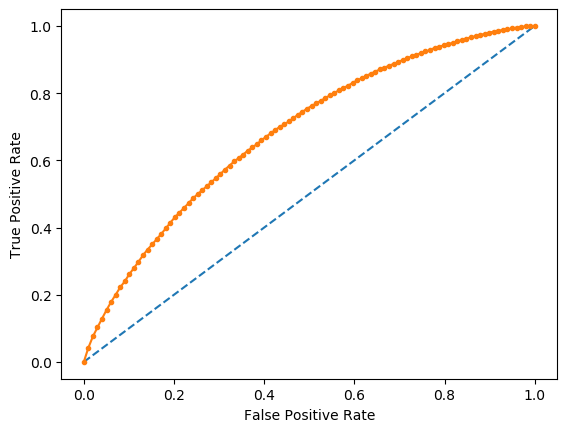

ROC AUC=0.685


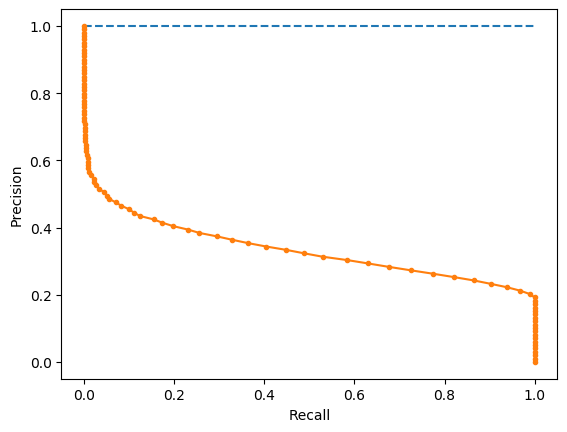

PR AUC=0.334


In [306]:
parameters= {'n_estimators': range(20,100,20),'max_depth':[8,9,10,11]}
model=RandomForestClassifier()
tuning(model,parameters)

### Model Interpretation with SHAP value <a class="anchor" id="4"></a>

In [27]:
#select 20% of the data
df_selected_sample=df_selected.sample(frac=0.2, random_state=1)
X=df_selected_sample.drop(columns=['loan_default'])
y=df_selected_sample[['loan_default']]
print(X.shape)
print(y.shape)

(16000, 30)
(16000, 1)


In [28]:
# Split the data into train and test data:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2,random_state=1)
print(X_train.shape)
print(y_train.shape)

(12800, 30)
(12800, 1)


In [29]:
# Build the model with the random forest regression algorithm:
rf = RandomForestClassifier(max_depth=10, n_estimators=80,random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=80, random_state=1)

#### Global Interpretability: Variable Importance Plot   <a class="anchor" id="4.1"></a>

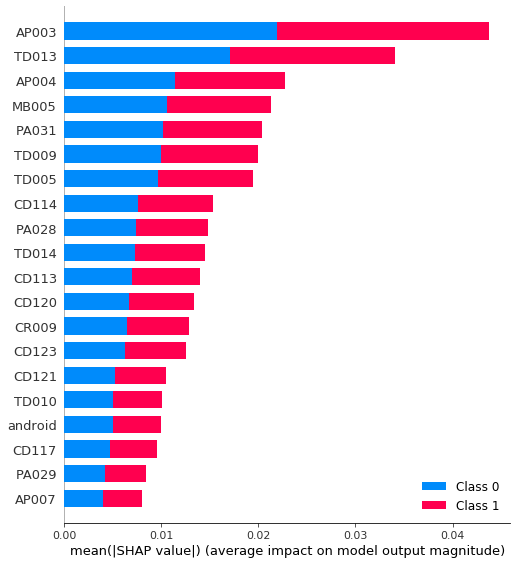

In [70]:
import shap
shap_values = shap.TreeExplainer(rf).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

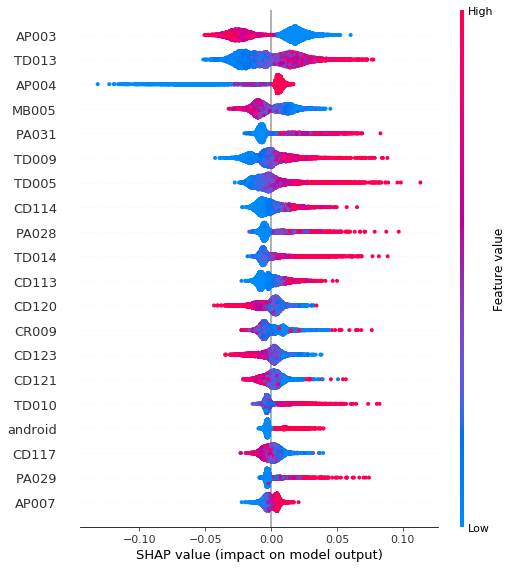

In [32]:
shap.summary_plot(shap_values[1], X_train)

The summary plot above shows that the most important features to determine default probability are education level(AP003), count of queries in the past certain period (TD013, TD009, TD005, TD014, TD010), loan term (AP004), Year_mobile_active (MB005) and collection call length related features (PA031, PA028). 

#### Global Interpretability: Dependence Plot   <a class="anchor" id="4.2"></a>

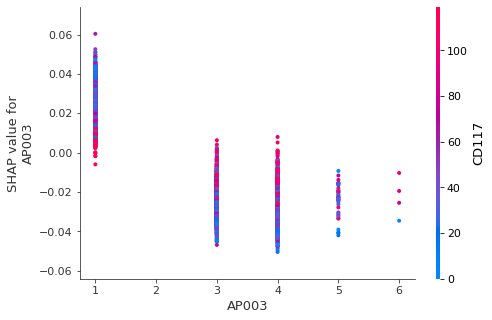

In [34]:
shap.dependence_plot('AP003', shap_values[1], X_train)

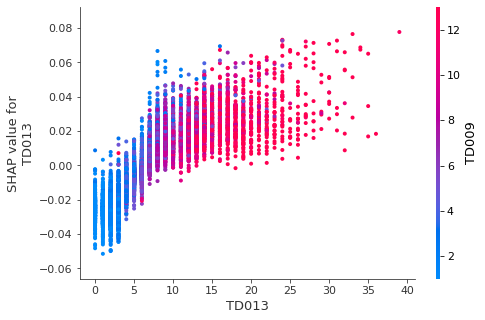

In [35]:
shap.dependence_plot('TD013', shap_values[1], X_train)

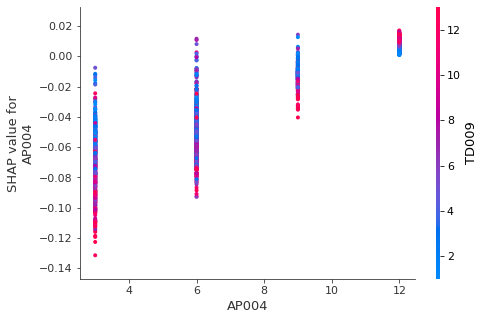

In [73]:
shap.dependence_plot('AP004', shap_values[1], X_train)

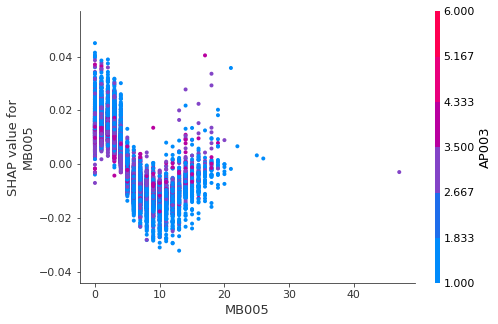

In [72]:
shap.dependence_plot('MB005', shap_values[1], X_train)

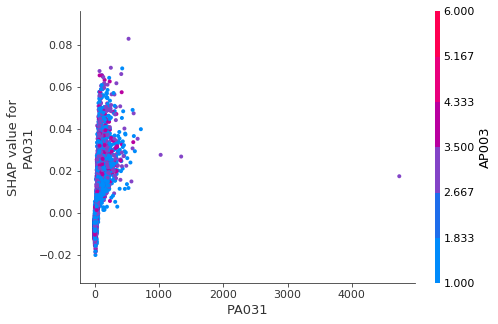

In [74]:
shap.dependence_plot('PA031', shap_values[1], X_train)

### Analysis of Top 5 features based in summary plot and dependence plot:

1. AP003: education level is negatively correlated with default probability. Combining with the result from dependence plot for AP003, clients with education level 1 are more likely to default while for clients with higher education levels (3,4,5,6) the default probabilities are similar.


2. TD013: number of queries on p2p platform during the past 6 months is positively correlated with default probability. This can be explained by that clients who made more queries either because they were declined more times before they got the loan or they had more loans than other clients, both of which can explain the higher default probability. Combining with the result from dependence plot for TD013, it's also positively correlated with TD009, which is another query number feature.


3. AP004: loan term is positively correlated with default probability. The longer the loan, the higher probability of default, which complies with economic rules as there are more uncertainties in long term. Combining with the result from dependence plot for AP004, it's also correlted with TD009. For lower loan term, the query time is negatively correlated with default probability, while for longer loan term, the query time is positively correlated with default probability.


4. MB005: The number of years the phone is active is negatively correlated with default probability. Combining with the result from dependence plot for MB005, however, the trend is a little bit different, before a certain years, the relationship is negative, while above a certain years, the relationship becomes positive. This can be explained by that below a certain year, the longer the more stable the client is, but above a certain year, the longer, the worse the financial status is for the client.


5. PA031: Average length of collection calls is positively correlated with default probability. This can be explained by that the longer the collection call means it's harder to collect, which leads to higher default probability.


#### Local Interpretability: Individual Force Plot

In [75]:
# Get the predictions and put them with the test data.
X_output = X_test.copy()
X_output.loc[:,'predict'] = np.round(rf.predict_proba(X_output)[:,1],2)

# Randomly pick some observations
random_picks = np.arange(1,3200,100) # Every 100 rows from test dataset
S = X_output.iloc[random_picks]
S.head()

,AP002,AP003,AP004,AP007,TD001,TD005,TD006,TD009,TD010,TD013,TD014,TD024,CR009,CR015,PA022,PA023,PA028,PA029,PA031,CD008,CD113,CD114,CD115,CD117,CD120,CD121,CD123,CD152,MB005,android,predict
271,1,4,12,2,2,4,1,7,1,10,2,8.0,114640,6,100.0,100.0,57.625,119.333333,57.625,20390.0,0.0,0.0,102.0,89.0,140.0,197.0,169.0,8487.0,7.0,0,0.21
46900,1,1,12,4,2,2,0,2,0,2,1,0.0,0,5,55.0,55.0,32.000,32.000000,32.000,10694.0,6.0,11.0,74.0,61.0,101.0,193.0,151.0,7685.0,9.0,0,0.14
59771,1,1,12,3,4,4,5,5,5,5,5,2.0,2500,6,84.0,84.0,65.625,64.285714,65.625,44794.0,7.0,8.0,183.0,162.0,249.0,322.0,294.0,21460.0,1.0,0,0.25
56397,1,3,12,3,1,6,1,6,3,8,4,4.0,109657,6,0.0,0.0,0.000,0.000000,0.000,10316.0,0.0,0.0,28.0,20.0,36.0,63.0,46.0,5660.0,3.0,1,0.17
35280,0,1,9,4,2,2,0,2,0,8,1,0.0,66000,5,106.0,0.0,74.000,74.000000,0.000,5367.0,1.0,1.0,27.0,21.0,39.0,62.0,49.0,3361.0,6.0,0,0.24


In [76]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(rf)
    shap_values = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value[1], shap_values[1][j], S.iloc[[j]])
    return(p)

In [77]:
shap_plot(1)

This observation has a default probability of 0.14, which is lower than the average base value. TD013, TD009 (lower query frequency), MB005 (more years for the phone to be active) have important negative impact on this result while AP003 (lower education level), PA031 (longer collection calls) and CD114 (higher number of days with abnormal hours call in the past 3 months) have important positive impact on this result.

In [78]:
shap_plot(2)

This observation has a default probability of 0.25, which is higher than the average base value. CD120 (number of distinct outbound calls in the past 2 months), CD123 (number of distinct outbound calls in the past 3 months) and CD115 (number of distinct calls in the past month) have important negative impact on this result while TD010 (more query on small loans in the past 3 months), TD014 (more query on small loans in the past 6 months), CD008 (length of total inbound calls in the past month) and PA029 (longer collection or high risk inbound calls) have important positive impact on this result. This client can possibily improve their credit profile by lowering their query frequency and avoid high risk calls.

In [79]:
shap_plot(3)

This observation has a default probability of 0.17, which is lower than the average base value. AP003 (higher education level), PA031(shorter length of collection call) and CD113, CD114 (zero abnormal hours call) have important negative impact on this result while MB005 (lower phone active year), android (operation system type) and TD013 (higher query frequency) have important positive impact on this result.

In [80]:
shap_plot(4)

This observation has a default probability of 0.24, which is higher than the average base value. AP004 (lower loan term), CR009 (lower loan amount), TD005 (lower query frequency on p2p over the past month) have important negative impact on this result while TD013 (higher query frequency on p2p over the past 6 months), AP003 (lower education level) and PA028(longer collection or high risk call) have important positive impact on this result.